In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import tensorflow as tf
import numpy as np

print(tf.__version__)

2.0.0


In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'
# 获取物理gpu, cpu对象
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
cpus = tf.config.experimental.list_physical_devices(device_type='CPU')

# 设置当前程序的　物理可见设备范围
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')

#设置仅在需要时申请：
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

# 设置在物理gpu上设置虚拟gpu，并用来限制gpu内存使用
tf.config.experimental.set_virtual_device_configuration(
    gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024), tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

# 获取当前虚拟gpu对象
logical_gpus = tf.config.experimental.list_logical_devices('GPU')

print('物理gpu个数: ', len(gpus))
print('总的gpu个数，其中包括括虚拟Logical gpus: ', len(logical_gpus))

物理gpu个数:  2
总的gpu个数，其中包括括虚拟Logical gpus:  2


In [4]:
# 获取数据
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train) , (x_test, y_test) = fashion_mnist.load_data()
# 定义预处理函数
def data_scale(x, y):
    x = tf.cast(x, tf.float32)
    # 由于还没有学卷积，所以需要把图片数据展开,28*28
    x = x / 255
    x = tf.reshape(x,(784, -1))    # (78,1)
    x = tf.squeeze(x)    # 降一个维度
    return x, y

train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_scale).cache().batch(64)
next(iter(train_db))# (64,784) (64,)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(data_scale).cache().batch(64)

In [5]:
# 熟悉函数
# 由于还没有学卷积，所以需要把图片数据展开，展开图像的长度为 28*28
num_inputs = 784
# 分类类别数为: 10 分类
num_outputs = 10
# 构建 X.W + B
W = tf.Variable(tf.random.normal(shape=(num_inputs, num_outputs),mean=0, stddev=0.1, dtype=tf.float32))
B = tf.Variable(tf.random.normal(shape=(1,10), mean=0.5, stddev=0.1, dtype=tf.float32))

In [6]:
# 感受一下 tf.reduce_sum计算
X = tf.constant([[1, 2, 3], [4, 5, 6]])

tf.reduce_sum(X, axis=0, keepdims=True), tf.reduce_sum(X, axis=1, keepdims=True),tf.reduce_sum(X)

(<tf.Tensor: id=80, shape=(1, 3), dtype=int32, numpy=array([[5, 7, 9]], dtype=int32)>,
 <tf.Tensor: id=82, shape=(2, 1), dtype=int32, numpy=
 array([[ 6],
        [15]], dtype=int32)>,
 <tf.Tensor: id=84, shape=(), dtype=int32, numpy=21>)

In [7]:
# tf.reduce_sum() 需要得到 batch_size * 1,所以axis=-1,即softmax的设计为
def softmax(logits, axis=-1):
    return tf.exp(logits)/tf.reduce_sum(tf.exp(logits), axis, keepdims=True)

In [8]:
# 再用一个简答的例子感受一下softmax函数的计算,转换后得到的是概率值且和为1
X = tf.random.normal(shape=(2, 5))
print(X)
X_prob = softmax(X)
X_prob, X_prob.shape, tf.reduce_sum(X_prob, axis=1)

tf.Tensor(
[[ 1.6769742   1.2339317  -0.8880535  -1.3728452  -1.0796046 ]
 [ 0.5351774  -0.7255373  -0.8779835  -0.04434932 -0.83744067]], shape=(2, 5), dtype=float32)


(<tf.Tensor: id=95, shape=(2, 5), dtype=float32, numpy=
 array([[0.54648596, 0.3508877 , 0.04203409, 0.02588566, 0.0347066 ],
        [0.4272719 , 0.12111081, 0.10398636, 0.2393421 , 0.10828888]],
       dtype=float32)>,
 TensorShape([2, 5]),
 <tf.Tensor: id=97, shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>)

In [9]:
# 定义模型
def softmax_net(X, W, B):
    logits = tf.matmul(tf.reshape(X, shape=(-1, W.shape[0])), W) + B
    return softmax(logits)

In [10]:
# 在定义损失函数前，再熟悉两个函数:
# 1、　tf.one_hot将类别 [0, 2, 1] 映射成 样本数*类别数 的　01向量
a = tf.constant([0,2,1])
a = tf.one_hot(a,depth=4)   # 得到 3*4的ont-hot矩阵

# 2、　tf.boolean_mask(a, b) 函数可以将a矩阵按照b中所有为true的位置抽取出来，放到一起，这里从n维降到1维度,可以想
# 可以想象成一张有洞的纸b覆盖在a上，把a上露出来的都挑出来
b = tf.constant([[0.3, 0.5, 0.1, 0.1],[0.1, 0.3, 0.4, 0.2],[0.1, 0.3, 0.4, 0.2]])
c = tf.boolean_mask(b, a)
a, c    # c:[0.3, 0.4, 0.3]　那么，这就是我们 loss = -sum(y * log(yhat))，其他的y为零，其实就是当y=1对应的，log(y_hat)的值 

(<tf.Tensor: id=102, shape=(3, 4), dtype=float32, numpy=
 array([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.]], dtype=float32)>,
 <tf.Tensor: id=130, shape=(3,), dtype=float32, numpy=array([0.3, 0.4, 0.3], dtype=float32)>)

In [11]:
# 定义损失函数

def cross_entropy(y_hat, y):
    y = tf.cast(tf.reshape(y, shape=[-1, 1]),dtype=tf.int32)
    y = tf.one_hot(y, depth=y_hat.shape[-1])    
    y = tf.cast(tf.reshape(y, shape=[-1, y_hat.shape[-1]]),dtype=tf.int32)
    return -tf.math.log(tf.boolean_mask(y_hat, y))


In [12]:
# 熟悉一下 tf.reduce_sum函数：
t = tf.constant([1,2,3,4,5,6])
s = tf.constant([1,2,4,4,0,6])
print(t == s)
print(tf.reduce_sum(tf.cast(t == s, dtype=tf.float16)))

tf.Tensor([ True  True False  True False  True], shape=(6,), dtype=bool)
tf.Tensor(4.0, shape=(), dtype=float16)


In [13]:
# 定义预测准确率计算函数,用来评价在测试集上的准确率
# def accuracy(y_hat, y):
#     return np.mean((tf.argmax(y_hat, axis=1) == tf.cast(y,dtype=tf.int64)))    # 这里y的类型不做转换容易报错

def evaluate_accuracy(data_iter, softmax_net):
    acc_sum, n = 0, 0.0
    for x, y in data_iter:
        yhat = softmax_net(x, W, B)
        acc_sum += tf.reduce_sum(tf.cast(tf.argmax(yhat, axis=1) == tf.cast(y, dtype=tf.int64), dtype=tf.float32))
        n += y.shape[0]
    return acc_sum / n

In [14]:
# 可以先测一下随机初始化的参数大致准确率
# (x_test, y_test) = next(iter(train_db))
# print(x_test, y_test)
# yhat = softmax_net(x_test, W, B)
# print(yhat)
# ac = accuracy(yhat, y_test)
# print(ac)    # 0.03125
acc = evaluate_accuracy(test_db, softmax_net)
print(acc)

tf.Tensor(0.1421, shape=(), dtype=float32)


In [15]:
# 训练模型
epoches = 20
lr = 1e-3

trainer = tf.keras.optimizers.SGD(lr)

def train_model(trainer=trainer):
    for epoch in range(epoches):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0.0
        for (x_in, y_in) in train_db:
            # 创建上下文管理器，链接需要计算梯度的函数和变量
            with tf.GradientTape() as tape:
                y_out = softmax_net(x_in, W, B)
                loss = tf.reduce_sum(cross_entropy(y_out, y_in))
#                 print('loss', loss)
            # 自动观测可训练变量
            grads = tape.gradient(loss, [W, B])
            # grads = tape.gradient(loss, softmax_net.trainable_variables)
            if trainer:
                # 使用优化器自动更新参数
                trainer.apply_gradients(zip(grads, [W,B]))
            else:
                # 手动更新参数
                W.assign_sub(grads[0] * lr)
                B.assign_sub(grads[1] * lr)
            # 计算训练集批量平均准确率和累计平均损失,注意这样做主要是为了方便计算，更合理应该计算全局损失和准确率,但是又需要重新计算，耗时较长
            train_acc_sum += tf.reduce_sum(tf.cast(tf.argmax(y_out, axis=1) == tf.cast(y_in, dtype=tf.int64), dtype=tf.float32))
#             print(loss)
            train_l_sum += loss
            # 样本个数：
            n += y_in.shape[0]
        test_acc = evaluate_accuracy(test_db, softmax_net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

# train_model()
train_model(trainer=None)

W0217 11:43:08.397786 139646339430208 deprecation.py:323] From /home/zero/anaconda3/envs/tf2/lib/python3.6/site-packages/tensorflow_core/python/ops/array_grad.py:502: _EagerTensorBase.cpu (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.identity instead.


epoch 1, loss 0.6704, train acc 0.774, test acc 0.812
epoch 2, loss 0.5117, train acc 0.827, test acc 0.825
epoch 3, loss 0.4795, train acc 0.837, test acc 0.830
epoch 4, loss 0.4621, train acc 0.842, test acc 0.834
epoch 5, loss 0.4507, train acc 0.846, test acc 0.835
epoch 6, loss 0.4424, train acc 0.848, test acc 0.837
epoch 7, loss 0.4360, train acc 0.850, test acc 0.839
epoch 8, loss 0.4308, train acc 0.852, test acc 0.839
epoch 9, loss 0.4265, train acc 0.854, test acc 0.840
epoch 10, loss 0.4229, train acc 0.855, test acc 0.841
epoch 11, loss 0.4197, train acc 0.856, test acc 0.841
epoch 12, loss 0.4170, train acc 0.857, test acc 0.842
epoch 13, loss 0.4145, train acc 0.857, test acc 0.842
epoch 14, loss 0.4123, train acc 0.858, test acc 0.843
epoch 15, loss 0.4103, train acc 0.858, test acc 0.843
epoch 16, loss 0.4085, train acc 0.859, test acc 0.843
epoch 17, loss 0.4068, train acc 0.859, test acc 0.843
epoch 18, loss 0.4053, train acc 0.860, test acc 0.844
epoch 19, loss 0.40

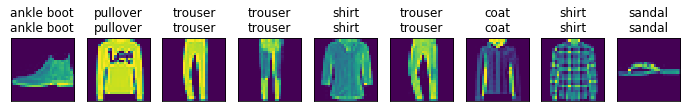

In [16]:
import matplotlib.pyplot as plt
X, y = iter(test_db).next()

def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_fashion_mnist(images, labels):
    # 这⾥的_表示我们忽略（不使⽤）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12)) # 这里注意subplot 和subplots 的区别
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(tf.reshape(img, shape=(28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(tf.argmax(softmax_net(X,W,B), axis=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

show_fashion_mnist(X[0:9], titles[0:9])